# Convolutional neural networks for semantic segmentation

## Get the data 

Here's a link to the tar with the dataset splitted into train and validation set. Execute the following lines or download and unpack the archive manually. 

In [1]:
! wget https://www.dropbox.com/s/73uav2bhlc88z1k/hp4x.tar.gz?dl=0 -O data.tar.gz
! tar -zxf data.tar.gz

--2018-04-12 17:45:58--  https://www.dropbox.com/s/73uav2bhlc88z1k/hp4x.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/RvKFpHmK8joTKpcUGTS7C2AmYFSxVuCalyqyj66m9nSmdQD76PDRCHiUOPwZf9as/file [following]
--2018-04-12 17:45:59--  https://dl.dropboxusercontent.com/content_link/RvKFpHmK8joTKpcUGTS7C2AmYFSxVuCalyqyj66m9nSmdQD76PDRCHiUOPwZf9as/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6, 2620:100:6021:6::a27d:4106
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68519950 (65M) [application/octet-stream]
Saving to: 'data.tar.gz'

data.tar.gz         100%[===================>]  65.35M  5.96MB/s    in 16s     

2018-

## Introduction

The problem offered to you is multi-class semantic segmentation. We provide you with an implementation of a Dataset file and a couple of handy transforms that will save you some time. You will have to code your own augmentations though -- for this task they will likely be slightly different. 

The evaluation metric for this problem is unweighted Mean Intersection over Union (mIoU) over all classes. But we ask you to report not only the mIoU score, but also IoU scores for each class. 

## Dataset 

This is a 4x-downsampled version of HumanParsing dataset, with all original labels merged into three groups:

    1. Background
    2. Clothes
    3. Body part
    
Each photo is a 150x100 RGB image.
  
This problem is more complex than image classification and is computationally intensive. Design you experiment accordingly, aiming as quick feedback on your ideas. It's time to apply every method and trick you've learned during the course. To achieve higher scores we suggest the following:

    1. Read more about multi-class segmentation nets and state of the art convolutional encoder-decoders
    2. User pretrained (at least, partially) networks for encoding
    3. Try some augmentation (look into torchvision package)
    4. Experiment with learning rate, scheduled learning rate and class weighting. 
    
The classes are imbalanced, although less so than they are in the real dataset. You will need to come up with a way to mitigate that.


## Grading

60% - 0.6 mIoU
70% - 0.7 mIoU
80% - 0.8 mIoU

Remaining 20% will be given for the quality of the report and deep analysis.

In [1]:
import sys
sys.path.append('/home/chuikova/chuikova2/lib/python2.7/site-packages/')
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

In [16]:
torch.cuda.set_device(1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


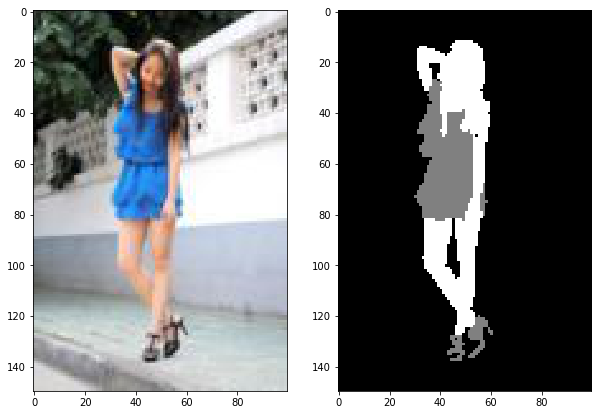

In [3]:

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('humanparsing-4x/valid/imgs/997_399.jpg')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('humanparsing-4x/valid/maps/997_399.png')
plt.imshow(mask, 'gray')

In [4]:
from humanparsing import HumanParsing, fast_hist, per_class_iu
from torch.utils.data import DataLoader

In [5]:
train_data = HumanParsing(data_dir='./humanparsing-4x/train/', augmentation=None)
valid_data = HumanParsing(data_dir='./humanparsing-4x/valid/', augmentation=None)

print('{} images in train set, {} in validation set'.format(len(train_data), len(valid_data)))

batch_size = 13

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=1)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size, num_workers=1)

14533 images in train set, 1615 in validation set


In [6]:
vgg16 = torchvision.models.vgg16_bn(pretrained=True)

In [7]:
weights = vgg16.state_dict()

In [8]:
vgg16.children

<bound method VGG.children of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e

In [76]:
import time

def compute_loss(X_batch, y_batch, model, weight_list = None):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model(X_batch)
    if weight_list:
        weight_list = torch.Tensor(weight_list).cuda()
    return nn.NLLLoss2d(weight=weight_list)(logits, y_batch).cuda()

def  IoU(y_true, y_pred, label):
    comp1 = y_true == label
    comp2 = y_pred == label
    
    overlap = comp1*comp2 
    union = comp1 + comp2
    
    if float(union.sum()) == 0.:
        IOU = 1.
    else:
        IOU = overlap.sum()/float(union.sum()) 
    return IOU

def  mIoU(y_true, y_pred, printing = False):
    iou_0 = IoU(y_true, y_pred, 0)
    iou_1 = IoU(y_true, y_pred, 1)
    iou_2 = IoU(y_true, y_pred, 2)
    if printing:
        print('IoU for label 0: ', iou_0)
        print('IoU for label 1: ', iou_1)
        print('IoU for label 1: ', iou_1)
        print('mIoU: {}'.format((iou_0 + iou_1 + iou_2)/3.))
    return iou_0, iou_1, iou_2, (iou_0 + iou_1 + iou_2)/3.


def training(model, opt, num_epochs, weight_list = None, aug = False):  
    
    for epoch in range(num_epochs):
    
        start_time = time.time()
        model.train(True)

        metric= []
        iou_0_arr = []
        iou_1_arr = []
        iou_2_arr = []
        train_loss = []

        if aug: 
            train = train_loader_aug
        else:
            train = train_loader
            
        for X_batch, y_batch in train:

            loss = compute_loss(X_batch, y_batch, model, weight_list)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.cpu().data.numpy()[0])

        model.train(False)
        for X_batch, y_batch in valid_loader:

            logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
            y_pred = logits.max(1)[1].cpu().data.numpy()
            iou_0, iou_1, iou_2, miou = mIoU(y_batch.numpy(), y_pred)
            metric.append(miou)
            iou_0_arr.append(iou_0)
            iou_1_arr.append(iou_1)
            iou_2_arr.append(iou_2)

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss)))
        print("                          miou: \t{:.2f} %".format(
            np.mean(metric) * 100))
        print("                     iou for 0: \t{:.2f} %".format(
            np.mean(iou_0_arr) * 100))
        print("                     iou for 1: \t{:.2f} %".format(
            np.mean(iou_1_arr) * 100))
        print("                     iou for 2: \t{:.2f} %".format(
            np.mean(iou_2_arr) * 100))
        print('\n')

In [10]:
from layer_wrappers import *

class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()
        
        #encoder part
        self.conv_0_enc = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, weight_init=weights['features.0.weight'], 
                                        bias_init=weights['features.0.bias'])
        self.bn_1_enc = BatchNorm2d(64, weight_init=weights['features.1.weight'], 
                                        bias_init=weights['features.1.bias'])

        self.conv_3_enc = Conv2d(64, 64, kernel_size=3, stride=1, padding=1, weight_init=weights['features.3.weight'], 
                                        bias_init=weights['features.3.bias'])
        self.bn_4_enc = BatchNorm2d(64, weight_init=weights['features.4.weight'], 
                                        bias_init=weights['features.4.bias'])

        #self.mp_6 = nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=False)
        self.conv_7_enc = Conv2d(64, 128, kernel_size=3, stride=1, padding=1, weight_init=weights['features.7.weight'], 
                                        bias_init=weights['features.7.bias'])
        self.bn_8_enc = BatchNorm2d(128, weight_init=weights['features.8.weight'], 
                                        bias_init=weights['features.8.bias'])

        self.conv_10_enc = Conv2d(128, 128, kernel_size=3, stride=1, padding=1, weight_init=weights['features.10.weight'], 
                                        bias_init=weights['features.10.bias'])
        self.bn_11_enc = BatchNorm2d(128, weight_init=weights['features.11.weight'], 
                                        bias_init=weights['features.11.bias'])

        #self.mp_13 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
        self.conv_14_enc = Conv2d(128, 256, kernel_size=3, stride=1, padding=1, weight_init=weights['features.14.weight'], 
                                        bias_init=weights['features.14.bias'])
        self.bn_15_enc = BatchNorm2d(256, weight_init=weights['features.15.weight'], 
                                        bias_init=weights['features.15.bias'])

        self.conv_17_enc = Conv2d(256, 256, kernel_size=3, stride=1, padding=1, weight_init=weights['features.17.weight'], 
                                        bias_init=weights['features.17.bias'])
        self.bn_18_enc = BatchNorm2d(256, weight_init=weights['features.18.weight'], 
                                        bias_init=weights['features.18.bias'])

        self.conv_20_enc = Conv2d(256, 256, kernel_size=3, stride=1, padding=1, weight_init=weights['features.20.weight'], 
                                        bias_init=weights['features.20.bias'])
        self.bn_21_enc = BatchNorm2d(256, weight_init=weights['features.21.weight'], 
                                        bias_init=weights['features.21.bias'])

        #self.mp_23 = MaxPool2d(kernel_size=2, stride=1, dilation=(1, 1), ceil_mode=False)
        self.conv_24_enc = Conv2d(256, 512, kernel_size=3, stride=1, padding=1, weight_init=weights['features.24.weight'], 
                                        bias_init=weights['features.24.bias'])
        self.bn_25_enc = BatchNorm2d(512, weight_init=weights['features.25.weight'], 
                                        bias_init=weights['features.25.bias'])

        self.conv_27_enc = Conv2d(512, 512, kernel_size=3, stride=1, padding=1, weight_init=weights['features.27.weight'], 
                                        bias_init=weights['features.27.bias'])
        self.bn_28_enc =  BatchNorm2d(512, weight_init=weights['features.28.weight'], 
                                        bias_init=weights['features.28.bias'])

        self.conv_30_enc = Conv2d(512, 512, kernel_size=3, stride=1, padding=1, weight_init=weights['features.30.weight'], 
                                        bias_init=weights['features.30.bias'])
        self.bn_31_enc =  BatchNorm2d(512, weight_init=weights['features.31.weight'], 
                                        bias_init=weights['features.31.bias'])

        #self.mp_33 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
        self.conv_34_enc = Conv2d(512, 512, kernel_size=3, stride=1, padding=1, weight_init=weights['features.34.weight'], 
                                        bias_init=weights['features.34.bias'])
        self.bn_35_enc = BatchNorm2d(512, weight_init=weights['features.35.weight'], 
                                        bias_init=weights['features.35.bias'])

        self.conv_37_enc =  Conv2d(512, 512, kernel_size=3, stride=1, padding=1, weight_init=weights['features.37.weight'], 
                                        bias_init=weights['features.37.bias'])
        self.bn_38_enc = BatchNorm2d(512, weight_init=weights['features.38.weight'], 
                                        bias_init=weights['features.38.bias'])

        self.conv_40_enc =  Conv2d(512, 512, kernel_size=3, stride=1, padding=1, weight_init=weights['features.40.weight'], 
                                        bias_init=weights['features.40.bias'])
        self.bn_41_enc =  BatchNorm2d(512, weight_init=weights['features.41.weight'], 
                                        bias_init=weights['features.41.bias'])
        
        
        #decoder part 
        self.conv_41_dec = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn_40_dec = nn.BatchNorm2d(512)

        self.conv_38_dec =  nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn_37_dec = nn.BatchNorm2d(512)

        self.conv_35_dec =  nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn_34_dec =  nn.BatchNorm2d(512)
        
        
        self.conv_31_dec = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn_30_dec = nn.BatchNorm2d(512)

        self.conv_28_dec = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn_27_dec =  nn.BatchNorm2d(512)

        self.conv_25_dec = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.bn_24_dec =  nn.BatchNorm2d(256)
        
        
        self.conv_21_dec = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn_20_dec = nn.BatchNorm2d(256)
        
        self.conv_18_dec = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn_17_dec = nn.BatchNorm2d(256)

        self.conv_15_dec = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn_14_dec = nn.BatchNorm2d(128)
        
        
        self.conv_11_dec = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn_10_dec = nn.BatchNorm2d(128)
        
        
        self.conv_8_dec = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn_7_dec = nn.BatchNorm2d(64)

        
        self.conv_4_dec = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn_3_dec = nn.BatchNorm2d(64)
        
        self.conv_1_dec = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        self.bn_0_dec = nn.BatchNorm2d(3)


    def forward(self, input):

        #encoding
        output = F.relu(self.bn_1_enc(self.conv_0_enc(input)),  inplace=True)
        output = F.relu(self.bn_4_enc(self.conv_3_enc(output)), inplace=True)
        size_1 = output.size()
        output, mp_1 = F.max_pool2d(output, kernel_size=2, stride=2, return_indices=True)
        
        output = F.relu(self.bn_8_enc(self.conv_7_enc(output)),  inplace=True)
        output = F.relu(self.bn_11_enc(self.conv_10_enc(output)),inplace=True)
        size_2 = output.size()
        output, mp_2 = F.max_pool2d(output, kernel_size=2, stride=2, return_indices=True)
        
        output = F.relu(self.bn_15_enc(self.conv_14_enc(output)),inplace=True)
        output = F.relu(self.bn_18_enc(self.conv_17_enc(output)),inplace=True)
        output = F.relu(self.bn_21_enc(self.conv_20_enc(output)),inplace=True)
        size_3 = output.size()
        output, mp_3 = F.max_pool2d(output,kernel_size=2, stride=2, return_indices=True)
        
        output = F.relu(self.bn_25_enc(self.conv_24_enc(output)),inplace=True)
        output = F.relu(self.bn_28_enc(self.conv_27_enc(output)),inplace=True)
        output = F.relu(self.bn_31_enc(self.conv_30_enc(output)),inplace=True)
        size_4 = output.size()
        output, mp_4 = F.max_pool2d(output,kernel_size=2, stride=2, return_indices=True)
        
        output = F.relu(self.bn_35_enc(self.conv_34_enc(output)),inplace=True)
        output = F.relu(self.bn_38_enc(self.conv_37_enc(output)),inplace=True)
        output = F.relu(self.bn_41_enc(self.conv_40_enc(output)),inplace=True)
        size_5 = output.size()
        output, mp_5 = F.max_pool2d(output,kernel_size=2, stride=2, return_indices=True)

        #decoding        
        output = F.max_unpool2d(output, mp_5, kernel_size=2, stride=2, output_size=size_5)
        output = F.relu(self.bn_40_dec(self.conv_41_dec(output)),inplace=True)
        output = F.relu(self.bn_37_dec(self.conv_38_dec(output)),inplace=True)
        output = F.relu(self.bn_34_dec(self.conv_35_dec(output)),inplace=True)
     
        output = F.max_unpool2d(output, mp_4, kernel_size=2, stride=2, output_size=size_4)
        output = F.relu(self.bn_30_dec(self.conv_31_dec(output)),inplace=True)
        output = F.relu(self.bn_27_dec(self.conv_28_dec(output)),inplace=True)
        output = F.relu(self.bn_24_dec(self.conv_25_dec(output)),inplace=True)

        output = F.max_unpool2d(output, mp_3, kernel_size=2, stride=2, output_size=size_3)
        output = F.relu(self.bn_20_dec(self.conv_21_dec(output)),inplace=True)
        output = F.relu(self.bn_17_dec(self.conv_18_dec(output)),inplace=True)
        output = F.relu(self.bn_14_dec(self.conv_15_dec(output)),inplace=True)

        output = F.max_unpool2d(output, mp_2, kernel_size=2, stride=2, output_size=size_2)
        output = F.relu(self.bn_10_dec(self.conv_11_dec(output)),inplace=True)
        output = F.relu(self.bn_7_dec(self.conv_8_dec(output)),  inplace=True)

        output = F.max_unpool2d(output, mp_1, kernel_size=2, stride=2, output_size=size_1)
        output = F.relu(self.bn_3_dec(self.conv_4_dec(output)),inplace=True)
        output = F.relu(self.bn_0_dec(self.conv_1_dec(output)),inplace=True)   
        output = F.log_softmax(output, dim = 1)

        return output

In [38]:
from layer_wrappers import *

class SegNet(nn.Module):
    def __init__(self, init = 'xavier_uniform'):
        super(SegNet, self).__init__()
        
        #encoder part
        self.conv_0_enc = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, weight_init=weights['features.0.weight'], 
                                        bias_init=weights['features.0.bias'])
        self.bn_1_enc = BatchNorm2d(64, weight_init=weights['features.1.weight'], 
                                        bias_init=weights['features.1.bias'])

        self.conv_3_enc = Conv2d(64, 64, kernel_size=3, stride=1, padding=1, weight_init=weights['features.3.weight'], 
                                        bias_init=weights['features.3.bias'])
        self.bn_4_enc = BatchNorm2d(64, weight_init=weights['features.4.weight'], 
                                        bias_init=weights['features.4.bias'])

        #self.mp_6 = nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=False)
        self.conv_7_enc = Conv2d(64, 128, kernel_size=3, stride=1, padding=1, weight_init=weights['features.7.weight'], 
                                        bias_init=weights['features.7.bias'])
        self.bn_8_enc = BatchNorm2d(128, weight_init=weights['features.8.weight'], 
                                        bias_init=weights['features.8.bias'])

        self.conv_10_enc = Conv2d(128, 128, kernel_size=3, stride=1, padding=1, weight_init=weights['features.10.weight'], 
                                        bias_init=weights['features.10.bias'])
        self.bn_11_enc = BatchNorm2d(128, weight_init=weights['features.11.weight'], 
                                        bias_init=weights['features.11.bias'])

        #self.mp_13 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
        self.conv_14_enc = Conv2d(128, 256, kernel_size=3, stride=1, padding=1, weight_init=weights['features.14.weight'], 
                                        bias_init=weights['features.14.bias'])
        self.bn_15_enc = BatchNorm2d(256, weight_init=weights['features.15.weight'], 
                                        bias_init=weights['features.15.bias'])

        self.conv_17_enc = Conv2d(256, 256, kernel_size=3, stride=1, padding=1, weight_init=weights['features.17.weight'], 
                                        bias_init=weights['features.17.bias'])
        self.bn_18_enc = BatchNorm2d(256, weight_init=weights['features.18.weight'], 
                                        bias_init=weights['features.18.bias'])

        self.conv_20_enc = Conv2d(256, 256, kernel_size=3, stride=1, padding=1, weight_init=weights['features.20.weight'], 
                                        bias_init=weights['features.20.bias'])
        self.bn_21_enc = BatchNorm2d(256, weight_init=weights['features.21.weight'], 
                                        bias_init=weights['features.21.bias'])

        #self.mp_23 = MaxPool2d(kernel_size=2, stride=1, dilation=(1, 1), ceil_mode=False)
        self.conv_24_enc = Conv2d(256, 512, kernel_size=3, stride=1, padding=1, weight_init=weights['features.24.weight'], 
                                        bias_init=weights['features.24.bias'])
        self.bn_25_enc = BatchNorm2d(512, weight_init=weights['features.25.weight'], 
                                        bias_init=weights['features.25.bias'])

        self.conv_27_enc = Conv2d(512, 512, kernel_size=3, stride=1, padding=1, weight_init=weights['features.27.weight'], 
                                        bias_init=weights['features.27.bias'])
        self.bn_28_enc =  BatchNorm2d(512, weight_init=weights['features.28.weight'], 
                                        bias_init=weights['features.28.bias'])

        self.conv_30_enc = Conv2d(512, 512, kernel_size=3, stride=1, padding=1, weight_init=weights['features.30.weight'], 
                                        bias_init=weights['features.30.bias'])
        self.bn_31_enc =  BatchNorm2d(512, weight_init=weights['features.31.weight'], 
                                        bias_init=weights['features.31.bias'])

        #self.mp_33 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
        self.conv_34_enc = Conv2d(512, 512, kernel_size=3, stride=1, padding=1, weight_init=weights['features.34.weight'], 
                                        bias_init=weights['features.34.bias'])
        self.bn_35_enc = BatchNorm2d(512, weight_init=weights['features.35.weight'], 
                                        bias_init=weights['features.35.bias'])

        self.conv_37_enc =  Conv2d(512, 512, kernel_size=3, stride=1, padding=1, weight_init=weights['features.37.weight'], 
                                        bias_init=weights['features.37.bias'])
        self.bn_38_enc = BatchNorm2d(512, weight_init=weights['features.38.weight'], 
                                        bias_init=weights['features.38.bias'])

        self.conv_40_enc =  Conv2d(512, 512, kernel_size=3, stride=1, padding=1, weight_init=weights['features.40.weight'], 
                                        bias_init=weights['features.40.bias'])
        self.bn_41_enc =  BatchNorm2d(512, weight_init=weights['features.41.weight'], 
                                        bias_init=weights['features.41.bias'])
        
        
        if init == 'xavier_uniform':
            initial = nn.init.xavier_uniform
            initial_bn = nn.init.uniform
        if init == 'xavier_normal':
            initial = nn.init.xavier_normal
            initial_bn = nn.init.normal
            
        #decoder part 
        self.conv_41_dec = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        initial(self.conv_41_dec.weight)
        nn.init.constant(self.conv_41_dec.bias, 0.0)
        
        self.bn_40_dec = nn.BatchNorm2d(512)
        initial_bn(self.bn_40_dec.weight)
        nn.init.constant(self.bn_40_dec.bias, 0.0)

        self.conv_38_dec =  nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        initial(self.conv_38_dec.weight)
        nn.init.constant(self.conv_38_dec.bias, 0.0)
        
        self.bn_37_dec = nn.BatchNorm2d(512)
        initial_bn(self.bn_37_dec.weight)
        nn.init.constant(self.bn_37_dec.bias, 0.0)

        self.conv_35_dec =  nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        initial(self.conv_35_dec.weight)
        nn.init.constant(self.conv_35_dec.bias, 0.0)
        self.bn_34_dec =  nn.BatchNorm2d(512)
        initial_bn(self.bn_34_dec.weight)
        nn.init.constant(self.bn_34_dec.bias, 0.0)
        
        
        self.conv_31_dec = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        initial(self.conv_31_dec.weight)
        nn.init.constant(self.conv_31_dec.bias, 0.0)
        self.bn_30_dec = nn.BatchNorm2d(512)
        initial_bn(self.bn_30_dec.weight)
        nn.init.constant(self.bn_30_dec.bias, 0.0)

        self.conv_28_dec = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        initial(self.conv_28_dec.weight)
        nn.init.constant(self.conv_28_dec.bias, 0.0)
        self.bn_27_dec =  nn.BatchNorm2d(512)
        initial_bn(self.bn_27_dec.weight)
        nn.init.constant(self.bn_27_dec.bias, 0.0)

        self.conv_25_dec = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        initial(self.conv_25_dec.weight)
        nn.init.constant(self.conv_25_dec.bias, 0.0)
        self.bn_24_dec =  nn.BatchNorm2d(256)
        initial_bn(self.bn_24_dec.weight)
        nn.init.constant(self.bn_24_dec.bias, 0.0)
        
        
        self.conv_21_dec = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        initial(self.conv_21_dec.weight)
        nn.init.constant(self.conv_21_dec.bias, 0.0)
        self.bn_20_dec = nn.BatchNorm2d(256)
        initial_bn(self.bn_20_dec.weight)
        nn.init.constant(self.bn_20_dec.bias, 0.0)
        
        self.conv_18_dec = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        initial(self.conv_18_dec.weight)
        nn.init.constant(self.conv_18_dec.bias, 0.0)
        self.bn_17_dec = nn.BatchNorm2d(256)
        initial_bn(self.bn_17_dec.weight)
        nn.init.constant(self.bn_17_dec.bias, 0.0)

        self.conv_15_dec = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        initial(self.conv_15_dec.weight)
        nn.init.constant(self.conv_15_dec.bias, 0.0)
        self.bn_14_dec = nn.BatchNorm2d(128)
        initial_bn(self.bn_14_dec.weight)
        nn.init.constant(self.bn_14_dec.bias, 0.0)
        
        
        self.conv_11_dec = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        initial(self.conv_11_dec.weight)
        nn.init.constant(self.conv_11_dec.bias, 0.0)
        self.bn_10_dec = nn.BatchNorm2d(128)
        initial_bn(self.conv_11_dec.weight)
        nn.init.constant(self.conv_11_dec.bias, 0.0)
        
        
        self.conv_8_dec = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        initial(self.conv_8_dec.weight)
        nn.init.constant(self.conv_8_dec.bias, 0.0)
        self.bn_7_dec = nn.BatchNorm2d(64)
        initial_bn(self.bn_7_dec.weight)
        nn.init.constant(self.bn_7_dec.bias, 0.0)

        self.conv_4_dec = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        initial(self.conv_4_dec.weight)
        nn.init.constant(self.conv_4_dec.bias, 0.0)
        self.bn_3_dec = nn.BatchNorm2d(64)
        initial_bn(self.bn_3_dec.weight)
        nn.init.constant(self.bn_3_dec.bias, 0.0)
        
        self.conv_1_dec = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        initial(self.conv_1_dec.weight)
        nn.init.constant(self.conv_1_dec.bias, 0.0)
        self.bn_0_dec = nn.BatchNorm2d(3)
        initial_bn(self.bn_0_dec.weight)
        nn.init.constant(self.bn_0_dec.bias, 0.0)


    def forward(self, input):

        #encoding
        output = F.relu(self.bn_1_enc(self.conv_0_enc(input)),  inplace=True)
        output = F.relu(self.bn_4_enc(self.conv_3_enc(output)), inplace=True)
        size_1 = output.size()
        output, mp_1 = F.max_pool2d(output, kernel_size=2, stride=2, return_indices=True)
        
        output = F.relu(self.bn_8_enc(self.conv_7_enc(output)),  inplace=True)
        output = F.relu(self.bn_11_enc(self.conv_10_enc(output)),inplace=True)
        size_2 = output.size()
        output, mp_2 = F.max_pool2d(output, kernel_size=2, stride=2, return_indices=True)
        
        output = F.relu(self.bn_15_enc(self.conv_14_enc(output)),inplace=True)
        output = F.relu(self.bn_18_enc(self.conv_17_enc(output)),inplace=True)
        output = F.relu(self.bn_21_enc(self.conv_20_enc(output)),inplace=True)
        size_3 = output.size()
        output, mp_3 = F.max_pool2d(output,kernel_size=2, stride=2, return_indices=True)
        
        output = F.relu(self.bn_25_enc(self.conv_24_enc(output)),inplace=True)
        output = F.relu(self.bn_28_enc(self.conv_27_enc(output)),inplace=True)
        output = F.relu(self.bn_31_enc(self.conv_30_enc(output)),inplace=True)
        size_4 = output.size()
        output, mp_4 = F.max_pool2d(output,kernel_size=2, stride=2, return_indices=True)
        
        output = F.relu(self.bn_35_enc(self.conv_34_enc(output)),inplace=True)
        output = F.relu(self.bn_38_enc(self.conv_37_enc(output)),inplace=True)
        output = F.relu(self.bn_41_enc(self.conv_40_enc(output)),inplace=True)
        size_5 = output.size()
        output, mp_5 = F.max_pool2d(output,kernel_size=2, stride=2, return_indices=True)

        #decoding        
        output = F.max_unpool2d(output, mp_5, kernel_size=2, stride=2, output_size=size_5)
        output = F.relu(self.bn_40_dec(self.conv_41_dec(output)),inplace=True)
        output = F.relu(self.bn_37_dec(self.conv_38_dec(output)),inplace=True)
        output = F.relu(self.bn_34_dec(self.conv_35_dec(output)),inplace=True)
     
        output = F.max_unpool2d(output, mp_4, kernel_size=2, stride=2, output_size=size_4)
        output = F.relu(self.bn_30_dec(self.conv_31_dec(output)),inplace=True)
        output = F.relu(self.bn_27_dec(self.conv_28_dec(output)),inplace=True)
        output = F.relu(self.bn_24_dec(self.conv_25_dec(output)),inplace=True)

        output = F.max_unpool2d(output, mp_3, kernel_size=2, stride=2, output_size=size_3)
        output = F.relu(self.bn_20_dec(self.conv_21_dec(output)),inplace=True)
        output = F.relu(self.bn_17_dec(self.conv_18_dec(output)),inplace=True)
        output = F.relu(self.bn_14_dec(self.conv_15_dec(output)),inplace=True)

        output = F.max_unpool2d(output, mp_2, kernel_size=2, stride=2, output_size=size_2)
        output = F.relu(self.bn_10_dec(self.conv_11_dec(output)),inplace=True)
        output = F.relu(self.bn_7_dec(self.conv_8_dec(output)),  inplace=True)

        output = F.max_unpool2d(output, mp_1, kernel_size=2, stride=2, output_size=size_1)
        output = F.relu(self.bn_3_dec(self.conv_4_dec(output)),inplace=True)
        output = F.relu(self.bn_0_dec(self.conv_1_dec(output)),inplace=True)   
        output = F.log_softmax(output, dim = 1)

        return output

## Nothing interesting, just a network

# Different initializations

* without any
* xavier_uniform (uniform for batch norm)
* xavier_normal  (normal for batch norm)

In [70]:
# without any
model = SegNet().cuda()
opt = torch.optim.Adam(model.parameters())
training(model = model, opt = opt, num_epochs = 10)
torch.save(model.state_dict(), 'net.pt')

Epoch 1 of 10 took 280.976s
  training loss (in-iteration): 	0.631574
                          miou: 	75.45 %
                     iou for 0: 	94.67 %
                     iou for 1: 	73.33 %
                     iou for 2: 	58.34 %


Epoch 2 of 10 took 281.579s
  training loss (in-iteration): 	0.372177
                          miou: 	76.84 %
                     iou for 0: 	95.41 %
                     iou for 1: 	74.99 %
                     iou for 2: 	60.13 %


Epoch 3 of 10 took 281.912s
  training loss (in-iteration): 	0.213763
                          miou: 	78.41 %
                     iou for 0: 	95.78 %
                     iou for 1: 	77.06 %
                     iou for 2: 	62.39 %


Epoch 4 of 10 took 281.997s
  training loss (in-iteration): 	0.169746
                          miou: 	79.63 %
                     iou for 0: 	96.06 %
                     iou for 1: 	77.76 %
                     iou for 2: 	65.07 %


Epoch 5 of 10 took 281.623s
  training loss (in-iteratio

In [30]:
model = SegNet(init='xavier_uniform').cuda()
opt = torch.optim.Adam(model.parameters())
training(model = model, opt = opt, num_epochs = 10)
torch.save(model.state_dict(), 'uniform.pt')

Epoch 1 of 10 took 296.929s
  training loss (in-iteration): 	0.592772
                          miou: 	75.49 %
                     iou for 0: 	95.29 %
                     iou for 1: 	74.87 %
                     iou for 2: 	56.30 %


Epoch 2 of 10 took 298.570s
  training loss (in-iteration): 	0.287549
                          miou: 	78.87 %
                     iou for 0: 	96.04 %
                     iou for 1: 	77.91 %
                     iou for 2: 	62.67 %


Epoch 3 of 10 took 297.904s
  training loss (in-iteration): 	0.189677
                          miou: 	79.89 %
                     iou for 0: 	96.32 %
                     iou for 1: 	78.99 %
                     iou for 2: 	64.37 %


Epoch 4 of 10 took 297.582s
  training loss (in-iteration): 	0.149932
                          miou: 	80.43 %
                     iou for 0: 	96.51 %
                     iou for 1: 	79.10 %
                     iou for 2: 	65.67 %


Epoch 5 of 10 took 297.396s
  training loss (in-iteratio

In [34]:
model = SegNet(init='xavier_normal').cuda()
opt = torch.optim.Adam(model.parameters())
training(model = model, opt = opt, num_epochs = 10)
torch.save(model.state_dict(), 'norm.pt')

Epoch 1 of 10 took 297.179s
  training loss (in-iteration): 	0.481819
                          miou: 	75.90 %
                     iou for 0: 	94.93 %
                     iou for 1: 	73.75 %
                     iou for 2: 	59.01 %


Epoch 2 of 10 took 297.107s
  training loss (in-iteration): 	0.244981
                          miou: 	79.00 %
                     iou for 0: 	96.11 %
                     iou for 1: 	77.59 %
                     iou for 2: 	63.32 %


Epoch 3 of 10 took 297.774s
  training loss (in-iteration): 	0.172405
                          miou: 	80.35 %
                     iou for 0: 	96.27 %
                     iou for 1: 	78.88 %
                     iou for 2: 	65.89 %


Epoch 4 of 10 took 297.912s
  training loss (in-iteration): 	0.140687
                          miou: 	79.55 %
                     iou for 0: 	96.03 %
                     iou for 1: 	78.19 %
                     iou for 2: 	64.45 %


Epoch 5 of 10 took 297.967s
  training loss (in-iteratio

In [46]:
model = SegNet(init='xavier_normal').cuda()
opt = torch.optim.Adam(model.parameters())
training(model = model, opt = opt, num_epochs = 10)
torch.save(model.state_dict(), 'norm1.pt')

Epoch 1 of 10 took 296.930s
  training loss (in-iteration): 	0.480082
                          miou: 	78.77 %
                     iou for 0: 	95.81 %
                     iou for 1: 	77.71 %
                     iou for 2: 	62.79 %


Epoch 2 of 10 took 298.342s
  training loss (in-iteration): 	0.229983
                          miou: 	79.69 %
                     iou for 0: 	96.25 %
                     iou for 1: 	78.37 %
                     iou for 2: 	64.45 %


Epoch 3 of 10 took 298.165s
  training loss (in-iteration): 	0.157656
                          miou: 	81.73 %
                     iou for 0: 	96.59 %
                     iou for 1: 	80.70 %
                     iou for 2: 	67.90 %


Epoch 4 of 10 took 297.965s
  training loss (in-iteration): 	0.124791
                          miou: 	82.43 %
                     iou for 0: 	96.72 %
                     iou for 1: 	81.56 %
                     iou for 2: 	69.01 %


Epoch 5 of 10 took 297.243s
  training loss (in-iteratio

## Adding weighting for loss

In [50]:
model = SegNet(init='xavier_normal').cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
training(model = model, opt = opt, num_epochs = 10, weight_list=[0.05, 0.15, 0.8])

Epoch 1 of 10 took 297.134s
  training loss (in-iteration): 	0.409607
                          miou: 	74.51 %
                     iou for 0: 	93.73 %
                     iou for 1: 	73.20 %
                     iou for 2: 	56.61 %


Epoch 2 of 10 took 298.083s
  training loss (in-iteration): 	0.239938
                          miou: 	76.10 %
                     iou for 0: 	94.74 %
                     iou for 1: 	76.20 %
                     iou for 2: 	57.36 %


Epoch 3 of 10 took 300.685s
  training loss (in-iteration): 	0.188747
                          miou: 	76.23 %
                     iou for 0: 	94.50 %
                     iou for 1: 	75.92 %
                     iou for 2: 	58.28 %


Epoch 4 of 10 took 299.473s
  training loss (in-iteration): 	0.167328
                          miou: 	76.53 %
                     iou for 0: 	95.34 %
                     iou for 1: 	77.38 %
                     iou for 2: 	56.88 %


Epoch 5 of 10 took 298.425s
  training loss (in-iteratio

In [16]:
training(model = model, opt = opt, num_epochs = 10, weight_list=[1, 2, 6])

Epoch 1 of 10 took 298.563s
  training loss (in-iteration): 	0.592422
                          miou: 	71.42 %
                     iou for 0: 	93.67 %
                     iou for 1: 	68.73 %
                     iou for 2: 	51.87 %


Epoch 2 of 10 took 298.092s
  training loss (in-iteration): 	0.316037
                          miou: 	71.32 %
                     iou for 0: 	94.55 %
                     iou for 1: 	67.75 %
                     iou for 2: 	51.67 %


Epoch 3 of 10 took 298.744s
  training loss (in-iteration): 	0.235714
                          miou: 	75.16 %
                     iou for 0: 	95.60 %
                     iou for 1: 	71.94 %
                     iou for 2: 	57.94 %


Epoch 4 of 10 took 298.924s
  training loss (in-iteration): 	0.204031
                          miou: 	74.36 %
                     iou for 0: 	94.89 %
                     iou for 1: 	70.43 %
                     iou for 2: 	57.75 %


Epoch 5 of 10 took 298.020s
  training loss (in-iteratio

Process Process-19:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/chuikova/chuikova2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
    return recv()
  File "/home/chuikova/chuikova2/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()
KeyboardInterrupt
Exception socket.error: error(2, 'No such file or directory') in <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7efc2473bb90>> ignored


KeyboardInterrupt: 

# lr

### more Adam

In [51]:
model_lr = SegNet()
model_lr.load_state_dict(torch.load('norm1.pt'))
opt = torch.optim.Adam(model_lr.parameters(), lr=1e-4)
model_lr.cuda()
training(model = model_lr, opt = opt, num_epochs = 3)

Epoch 1 of 3 took 302.658s
  training loss (in-iteration): 	0.071627
                          miou: 	84.13 %
                     iou for 0: 	97.02 %
                     iou for 1: 	83.40 %
                     iou for 2: 	71.97 %


Epoch 2 of 3 took 298.766s
  training loss (in-iteration): 	0.068634
                          miou: 	84.10 %
                     iou for 0: 	97.01 %
                     iou for 1: 	83.34 %
                     iou for 2: 	71.95 %


Epoch 3 of 3 took 297.697s
  training loss (in-iteration): 	0.066847
                          miou: 	84.12 %
                     iou for 0: 	97.01 %
                     iou for 1: 	83.33 %
                     iou for 2: 	72.01 %




In [52]:
opt = torch.optim.Adam(model_lr.parameters(), lr=1e-5)
training(model = model_lr, opt = opt, num_epochs = 3)

Epoch 1 of 3 took 297.784s
  training loss (in-iteration): 	0.065139
                          miou: 	84.12 %
                     iou for 0: 	97.01 %
                     iou for 1: 	83.33 %
                     iou for 2: 	72.01 %


Epoch 2 of 3 took 298.233s
  training loss (in-iteration): 	0.064859
                          miou: 	84.14 %
                     iou for 0: 	97.01 %
                     iou for 1: 	83.34 %
                     iou for 2: 	72.06 %


Epoch 3 of 3 took 297.903s
  training loss (in-iteration): 	0.064713
                          miou: 	84.07 %
                     iou for 0: 	97.01 %
                     iou for 1: 	83.32 %
                     iou for 2: 	71.89 %




### f-tuning with SGD

In [53]:
model_lr = SegNet()
model_lr.load_state_dict(torch.load('norm1.pt'))
opt = torch.optim.SGD(model_lr.parameters(), lr=1e-4, momentum=0.9, nesterov=True)
model_lr.cuda()
training(model = model_lr, opt = opt, num_epochs = 3)

Epoch 1 of 3 took 291.150s
  training loss (in-iteration): 	0.076037
                          miou: 	83.35 %
                     iou for 0: 	96.90 %
                     iou for 1: 	82.43 %
                     iou for 2: 	70.70 %


Epoch 2 of 3 took 291.000s
  training loss (in-iteration): 	0.075844
                          miou: 	83.41 %
                     iou for 0: 	96.91 %
                     iou for 1: 	82.57 %
                     iou for 2: 	70.75 %


Epoch 3 of 3 took 291.245s
  training loss (in-iteration): 	0.075738
                          miou: 	83.33 %
                     iou for 0: 	96.92 %
                     iou for 1: 	82.47 %
                     iou for 2: 	70.59 %




### just SGD

In [55]:
model_lr = SegNet(init='xavier_normal').cuda()
opt = torch.optim.SGD(model_lr.parameters(), lr=1e-3)
training(model = model_lr, opt = opt, num_epochs = 5)

Epoch 1 of 5 took 286.609s
  training loss (in-iteration): 	1.141392
                          miou: 	34.98 %
                     iou for 0: 	80.16 %
                     iou for 1: 	21.08 %
                     iou for 2: 	3.71 %


Epoch 2 of 5 took 287.940s
  training loss (in-iteration): 	0.829773
                          miou: 	40.85 %
                     iou for 0: 	83.09 %
                     iou for 1: 	37.90 %
                     iou for 2: 	1.58 %


Epoch 3 of 5 took 289.388s
  training loss (in-iteration): 	0.686997
                          miou: 	43.37 %
                     iou for 0: 	84.40 %
                     iou for 1: 	44.38 %
                     iou for 2: 	1.32 %


Epoch 4 of 5 took 291.840s
  training loss (in-iteration): 	0.588712
                          miou: 	46.47 %
                     iou for 0: 	86.30 %
                     iou for 1: 	51.46 %
                     iou for 2: 	1.66 %


Epoch 5 of 5 took 291.093s
  training loss (in-iteration): 	0.52

### faster lr for SGD

In [56]:
model_lr = SegNet().cuda()
opt = torch.optim.SGD(model_lr.parameters(), lr=1e-2)
training(model = model_lr, opt = opt, num_epochs = 3)

Epoch 1 of 3 took 284.891s
  training loss (in-iteration): 	0.565020
                          miou: 	50.08 %
                     iou for 0: 	90.05 %
                     iou for 1: 	60.19 %
                     iou for 2: 	0.00 %


Epoch 2 of 3 took 283.823s
  training loss (in-iteration): 	0.312838
                          miou: 	51.73 %
                     iou for 0: 	91.45 %
                     iou for 1: 	63.75 %
                     iou for 2: 	0.01 %


Epoch 3 of 3 took 284.696s
  training loss (in-iteration): 	0.259956
                          miou: 	52.76 %
                     iou for 0: 	91.76 %
                     iou for 1: 	66.52 %
                     iou for 2: 	0.01 %




### SGD with momentum

In [57]:
model_lr = SegNet(init='xavier_normal').cuda()
opt = torch.optim.SGD(model_lr.parameters(), lr=1e-3, momentum=0.9, nesterov=True)
training(model = model_lr, opt = opt, num_epochs = 5)

Epoch 1 of 5 took 291.412s
  training loss (in-iteration): 	0.565791
                          miou: 	51.18 %
                     iou for 0: 	89.48 %
                     iou for 1: 	60.29 %
                     iou for 2: 	3.78 %


Epoch 2 of 5 took 291.195s
  training loss (in-iteration): 	0.301017
                          miou: 	63.37 %
                     iou for 0: 	91.95 %
                     iou for 1: 	66.68 %
                     iou for 2: 	31.48 %


Epoch 3 of 5 took 291.629s
  training loss (in-iteration): 	0.231756
                          miou: 	67.20 %
                     iou for 0: 	92.91 %
                     iou for 1: 	70.10 %
                     iou for 2: 	38.59 %


Epoch 4 of 5 took 291.698s
  training loss (in-iteration): 	0.201508
                          miou: 	68.77 %
                     iou for 0: 	93.18 %
                     iou for 1: 	71.24 %
                     iou for 2: 	41.90 %


Epoch 5 of 5 took 291.506s
  training loss (in-iteration): 	0

### RMSprop

In [58]:
model_lr = SegNet(init='xavier_normal').cuda()
opt = torch.optim.RMSprop(model_lr.parameters(), lr=1e-3)
training(model = model_lr, opt = opt, num_epochs = 5)

Epoch 1 of 5 took 293.369s
  training loss (in-iteration): 	0.260321
                          miou: 	79.76 %
                     iou for 0: 	96.18 %
                     iou for 1: 	78.57 %
                     iou for 2: 	64.53 %


Epoch 2 of 5 took 293.438s
  training loss (in-iteration): 	0.132422
                          miou: 	81.26 %
                     iou for 0: 	96.62 %
                     iou for 1: 	80.46 %
                     iou for 2: 	66.69 %


Epoch 3 of 5 took 293.600s
  training loss (in-iteration): 	0.102285
                          miou: 	81.47 %
                     iou for 0: 	96.56 %
                     iou for 1: 	80.88 %
                     iou for 2: 	66.97 %


Epoch 4 of 5 took 293.774s
  training loss (in-iteration): 	0.091512
                          miou: 	82.36 %
                     iou for 0: 	96.59 %
                     iou for 1: 	81.31 %
                     iou for 2: 	69.16 %


Epoch 5 of 5 took 294.133s
  training loss (in-iteration): 	

In [59]:
training(model = model_lr, opt = opt, num_epochs = 5)
torch.save(model_lr.state_dict(), 'norm_RMS.pt')

Epoch 1 of 5 took 293.773s
  training loss (in-iteration): 	0.081938
                          miou: 	82.67 %
                     iou for 0: 	96.85 %
                     iou for 1: 	81.93 %
                     iou for 2: 	69.23 %


Epoch 2 of 5 took 293.910s
  training loss (in-iteration): 	0.078238
                          miou: 	83.19 %
                     iou for 0: 	96.87 %
                     iou for 1: 	82.15 %
                     iou for 2: 	70.54 %


Epoch 3 of 5 took 293.557s
  training loss (in-iteration): 	0.075150
                          miou: 	83.40 %
                     iou for 0: 	96.88 %
                     iou for 1: 	82.45 %
                     iou for 2: 	70.86 %


Epoch 4 of 5 took 293.499s
  training loss (in-iteration): 	0.072941
                          miou: 	83.69 %
                     iou for 0: 	96.89 %
                     iou for 1: 	82.83 %
                     iou for 2: 	71.36 %


Epoch 5 of 5 took 294.315s
  training loss (in-iteration): 	

In [61]:
opt = torch.optim.RMSprop(model_lr.parameters(), lr=1e-4)
training(model = model_lr, opt = opt, num_epochs = 5)
torch.save(model_lr.state_dict(), 'norm_RMS1.pt')

Epoch 1 of 5 took 293.450s
  training loss (in-iteration): 	0.063108
                          miou: 	84.34 %
                     iou for 0: 	97.04 %
                     iou for 1: 	83.56 %
                     iou for 2: 	72.43 %


Epoch 2 of 5 took 293.251s
  training loss (in-iteration): 	0.060699
                          miou: 	84.35 %
                     iou for 0: 	97.04 %
                     iou for 1: 	83.56 %
                     iou for 2: 	72.45 %


Epoch 3 of 5 took 293.066s
  training loss (in-iteration): 	0.059308
                          miou: 	84.30 %
                     iou for 0: 	97.03 %
                     iou for 1: 	83.46 %
                     iou for 2: 	72.40 %


Epoch 4 of 5 took 293.259s
  training loss (in-iteration): 	0.058173
                          miou: 	84.27 %
                     iou for 0: 	97.03 %
                     iou for 1: 	83.43 %
                     iou for 2: 	72.35 %


Epoch 5 of 5 took 293.562s
  training loss (in-iteration): 	

In [63]:
opt = torch.optim.RMSprop(model_lr.parameters(), lr=1e-5)
training(model = model_lr, opt = opt, num_epochs = 2)

Epoch 1 of 2 took 293.215s
  training loss (in-iteration): 	0.056086
                          miou: 	84.21 %
                     iou for 0: 	97.02 %
                     iou for 1: 	83.40 %
                     iou for 2: 	72.22 %


Epoch 2 of 2 took 293.310s
  training loss (in-iteration): 	0.055892
                          miou: 	84.19 %
                     iou for 0: 	97.02 %
                     iou for 1: 	83.37 %
                     iou for 2: 	72.19 %




### Augmentations 

In [88]:
from torchvision import transforms

class RandomRotation:
    def __init__(self, degrees):
        self.degrees = degrees
        
    def __call__(self, img, mask):
        rot =  transforms.RandomRotation(self.degrees)
        img = rot(img)
        mask = rot(mask)
        return img, mask

In [91]:
train_data_aug = HumanParsing(data_dir='./humanparsing-4x/train/', augmentation = [RandomRotation(15)])
valid_data_aug = HumanParsing(data_dir='./humanparsing-4x/valid/', augmentation=None)

print('{} images in train set, {} in validation set'.format(len(train_data_aug), len(valid_data_aug)))

batch_size = 13

train_loader_aug = DataLoader(train_data_aug, shuffle=True, batch_size=batch_size, num_workers=1)
valid_loader_aug = DataLoader(valid_data_aug, shuffle=False, batch_size=batch_size, num_workers=1)

14533 images in train set, 1615 in validation set


In [92]:
model_lr = SegNet(init='xavier_normal').cuda()
opt = torch.optim.RMSprop(model_lr.parameters(), lr=1e-3)
training(model = model_lr, opt = opt, num_epochs = 5, aug=True)

Epoch 1 of 5 took 292.627s
  training loss (in-iteration): 	0.431736
                          miou: 	65.69 %
                     iou for 0: 	91.48 %
                     iou for 1: 	68.97 %
                     iou for 2: 	36.62 %


Epoch 2 of 5 took 292.944s
  training loss (in-iteration): 	0.303233
                          miou: 	66.65 %
                     iou for 0: 	91.28 %
                     iou for 1: 	69.12 %
                     iou for 2: 	39.57 %


Epoch 3 of 5 took 293.041s
  training loss (in-iteration): 	0.267961
                          miou: 	63.75 %
                     iou for 0: 	90.86 %
                     iou for 1: 	70.80 %
                     iou for 2: 	29.59 %


Epoch 4 of 5 took 293.336s
  training loss (in-iteration): 	0.253074
                          miou: 	68.98 %
                     iou for 0: 	91.98 %
                     iou for 1: 	69.41 %
                     iou for 2: 	45.56 %


Epoch 5 of 5 took 293.165s
  training loss (in-iteration): 	

## Report 

In the task I used:

* [SegNet](https://arxiv.org/pdf/1511.00561.pdf)  network
* diffirent optimizers (Adam, RMSprop, SGD)
* scheduling (decreasing learning rate)
* 2d loss for images
* weighting method (in-loss)
* augmentations (random rotation)
* fine-tuning
* different initializations 


At first, after googling SOTA segmentation methods SegNet network was found. SegNet architecture in based on VGG16 network - allows to use weights of the pretrained vgg16.

Initializations such as xavier_uniform (uniform for batch norm) and xavier_normal (normal for batch norm) were used. Also, network without initialization were tested. 

Among the three optimizers studied, the best results were shown by Adam, RMSprop. 

Learning rate decreasing allows to increase the metric (miou) by 2 percent.

Judging by the results, the Random Rotation augmentation method is not suitable for solving this problem.

Weighting method didn't work very well too.(?????)
    


### Methods


| method        | optimizer        | MIOU on val  | IOU on val for 0   |  IOU on val for 1   |  IOU on val for 2   |
| ------------- |:----------------:|  :-------------:|:----------------:|:-----------------:|:-------------------:|
| without init  | Adam (lr = 1e-3) | 81.08 %         | 96.43 %          | 80.05 %           | 66.76 %    |
| xavier_uniform | Adam (lr = 1e-3) | 82.79 %       | 96.77 %         | 81.89 %             | 69.71 %    |
| xavier_normal  | Adam (lr = 1e-3) | 83.27 %        |96.90 %         | 82.35 %          | 70.55 %   |
| xavier_normal  | Adam (lr = 1e-3, 1e-4) | 84.12 %         | 97.01 %        | 83.33 %           | 72.01 %    |
| xavier_normal  | Adam (lr = 1e-3)(SGD 1e-4) | 83.33 %        | 96.92 %        | 82.47 %          | 70.59 %   |
| xavier_normal  | RMSprop (lr = 1e-3) | 83.68 %         | 96.92 %       | 82.71 %         | 71.42 %    |
| $\textbf{xavier_normal} $ | $\textbf{RMSprop (lr = 1e-3, 1e-4)}$ | $\textbf{84.23 %  }$       | $\textbf{97.03 %   }$     | $\textbf{83.43 %}$         | $\textbf{72.25 %}$    |
| RandomRotation (5ep)  | RMSprop (lr = 1e-3| 68.21 %        | 91.76 %        | 68.83 %          | 44.04 %    |
| weight [0.05, 0.15, 0.8]  | Adam (lr = 1e-3) | 78.42 %       | 95.86 %         | 78.26 %        | 61.13 %    |

### Conclusions

* Pretrained models are VERY useful 
* Weight initialization is VERY useful too
* Augmentations not always can help
* Learning rate decreasing allows to increase the accuracy by final 1-2 %
* Diffetent optimizers for different tasks 